In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_excel('rnd_contest_data.xlsx', sheet_name='REF raw data')
data['Date'] = data["Year"].map(str) + ' ' + data["Month"]
data['Date'] = pd.to_datetime(data['Date'])
arima_data = data.loc[:,['Date', 'Source', 'Brand', 'Model', 'Sales Units']]
arima_data.set_index("Date", inplace = True)
arima_data.head()

,Source,Brand,Model,Sales Units
Date,,,,
2018-01-01,Traditional Sales,INDESIT,TIAA 14,581.000000
2018-01-01,Traditional Sales,WHIRLPOOL,BSNF 9121 OX,526.000000
2018-01-01,Traditional Sales,LG,GA-B429SECZ,521.400000
2018-01-01,Traditional Sales,SAMSUNG,RB37J5000SA/UA,515.000000
2018-01-01,Traditional Sales,SAMSUNG,RB37J5000EF/UA,496.966038


In [135]:
trad = arima_data[arima_data['Source']=='Traditional Sales']
sam_trad = trad[trad['Brand']=='SAMSUNG']
test_data = sam_trad[sam_trad['Model']=='RB37J5000SA/UA']
test_data_two = test_data.loc[:,['Sales Units']]
print('SAMSUNG -- RB37J5000SA/UA')
test_data_two.head()

SAMSUNG -- RB37J5000SA/UA


,Sales Units
Date,
2018-01-01,515.0
2018-02-01,482.0
2018-03-01,638.0
2018-04-01,584.0
2018-05-01,743.1


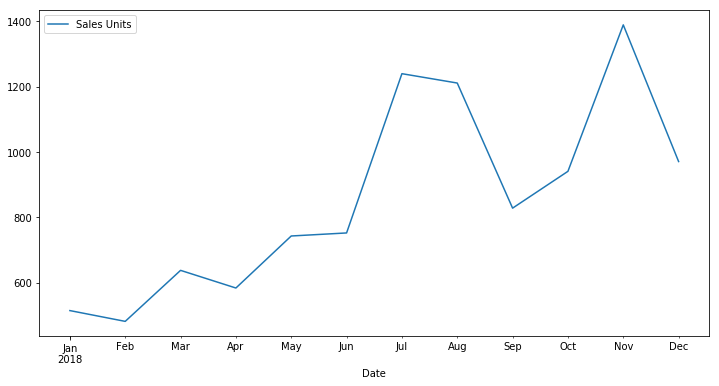

In [136]:
test_data_two.plot(kind='line', figsize=(12,6))

### Test for Stationarity

In [137]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [138]:
rolmean = test_data_two.rolling(2).mean()
rolstd = test_data_two.rolling(2).std()

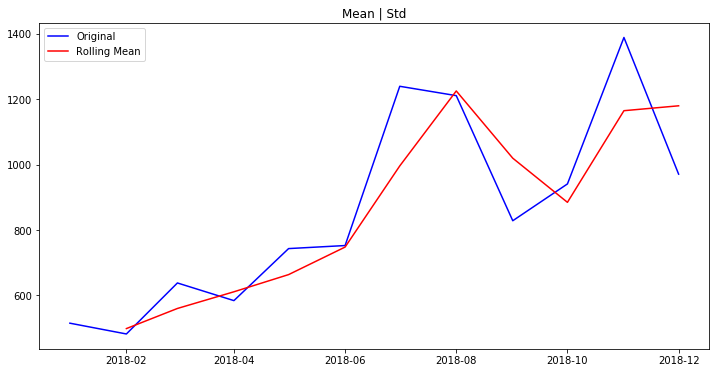

In [139]:
plt.figure(figsize = (12,6))
orig = plt.plot(test_data_two, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#std = plt.plot(rolstd, color='black', label='Rolling STD')
plt.title("Mean | Std")
plt.legend(loc='best')
plt.show()

In [140]:
data2diff = test_data_two.diff(periods=2).dropna()
test = sm.tsa.adfuller(data2diff.iloc[:,0])
print ('adf: ', test[0])
print ('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -7.741174858672461
p-value:  1.0609378712230833e-11
Critical values:  {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}
единичных корней нет, ряд стационарен


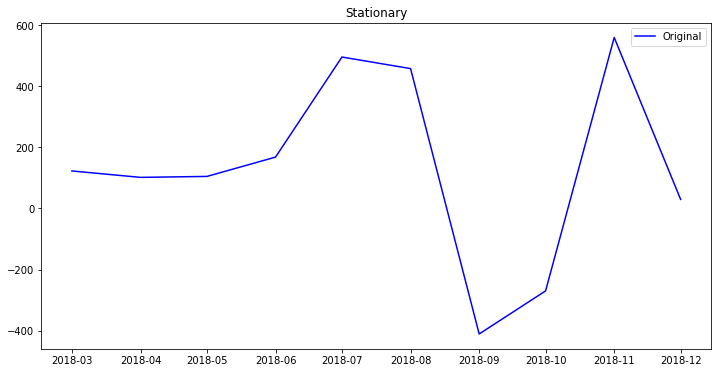

In [141]:
plt.figure(figsize = (12,6))
orig = plt.plot(data1diff, color='blue', label='Original')
plt.title("Stationary")
plt.legend(loc='best')
plt.show()

### ACF and 

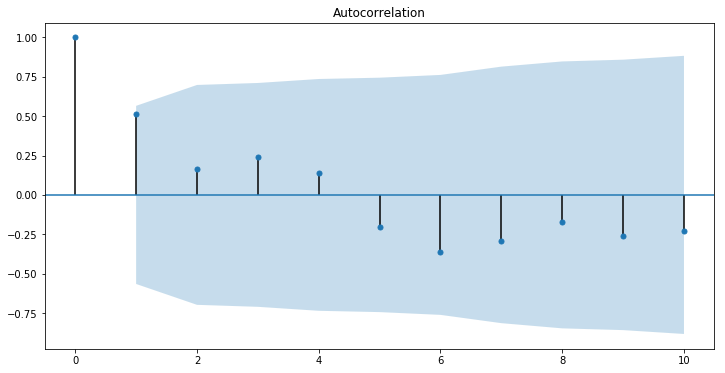

In [142]:
from statsmodels.graphics.tsaplots import plot_acf
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(test_data_two.iloc[:,0], lags=10, ax=ax)
plt.show()

C:\Users\denis\Anaconda37\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


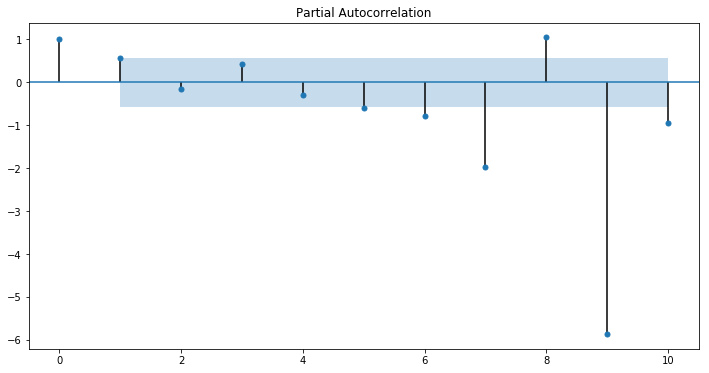

In [143]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, ax = plt.subplots(figsize=(12,6))
plot_pacf(test_data_two.values, lags=10, ax=ax)
plt.show()

### Build ARIMA Model

In [145]:
from statsmodels.tsa.arima_model import ARMA

ar1 = ARMA(tuple(data2diff.values), (1,5)).fit()
ar1.summary()

C:\Users\denis\Anaconda37\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                   10
Model:                     ARMA(1, 5)   Log Likelihood                 -66.568
Method:                       css-mle   S.D. of innovations            106.480
Date:                Fri, 31 Jan 2020   AIC                            149.136
Time:                        08:51:38   BIC                            151.556
Sample:                             0   HQIC                           146.480
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        130.3038     21.805      5.976      0.009      87.566     173.042
ar.L1.y       -0.4573      0.547     -0.836      0.464      -1.529       0.614
ma.L1.y        0.8609      0.928      0.928      0.422      -0.957       2.679
ma.L2.y       -1.8609      1.436     -1.296      0.286      -4.675       0.953
ma.L3.y       -1.8609      1.256     -1.481      0.235      -4.323       0.601
ma.L4.y        0.8609      1.299      0.663      0.555      -1.685       3.406
ma.L5.y        1.0000      0.927      1.079      0.360      -0.817       2.817
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1867           +0.0000j            2.1867            0.5000
MA.1            1.0000           -0.0004j            1.0000           -0.0001
MA.2            1.0000           +0.0004j            1.0000            0.0001
MA.3           -0.9304           -0.3665j            1.0000           -0.4403
MA.4           -0.9304           +0.3665j            1.0000            0.4403
MA.5           -1.0000           -0.0000j            1.0000           -0.5000
-----------------------------------------------------------------------------
"""

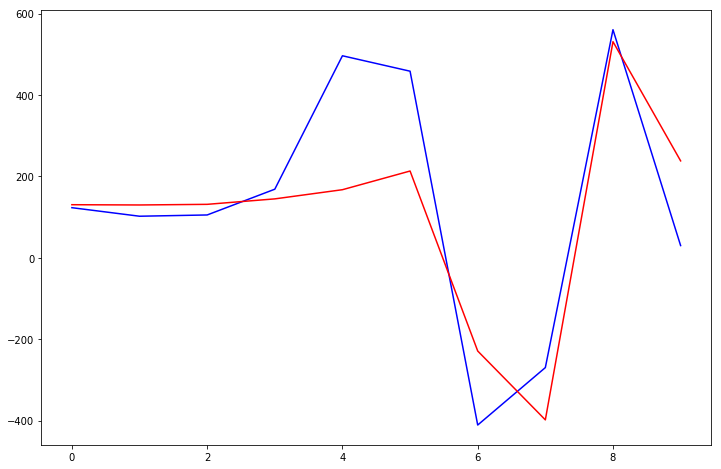

In [156]:
plt.figure(figsize=(12,8))
plt.plot(data2diff.values, color='blue')
preds = ar1.fittedvalues
plt.plot(preds, color='red')
plt.show()

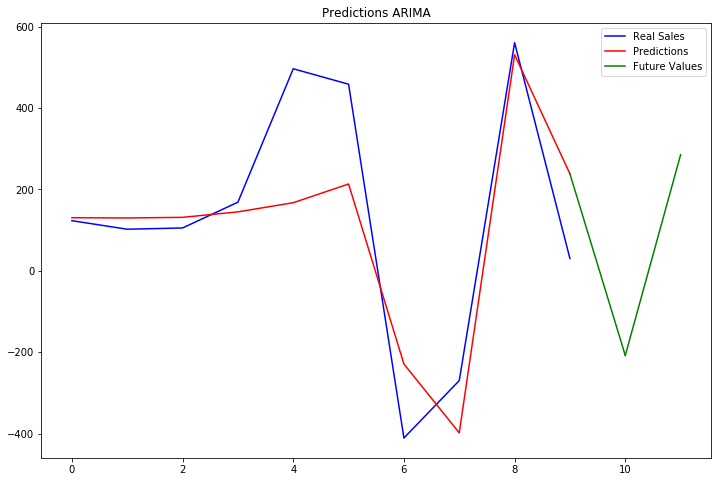

In [178]:
steps = 2
forecast = ar1.forecast(steps=steps)[0]
plt.figure(figsize=(12,8))
plt.plot(data2diff.values, color='blue', label='Real Sales')
preds=ar1.fittedvalues
plt.plot(preds, color='red', label="Predictions")
plt.plot(pd.DataFrame(np.array([preds[-1], forecast[0]]).T, index=range(len(data2diff.values)-1, len(data2diff.values)+1)), color = 'green', label="Future Values")
plt.plot(pd.DataFrame(forecast, index=range(len(data2diff.values), len(data2diff.values)+steps)), color='green')
plt.title("Predictions ARIMA")
plt.legend(loc='best')
plt.show()

### Neural Networks

C:\Users\denis\Anaconda37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\denis\Anaconda37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\denis\Anaconda37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\denis\Anaconda37\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y 

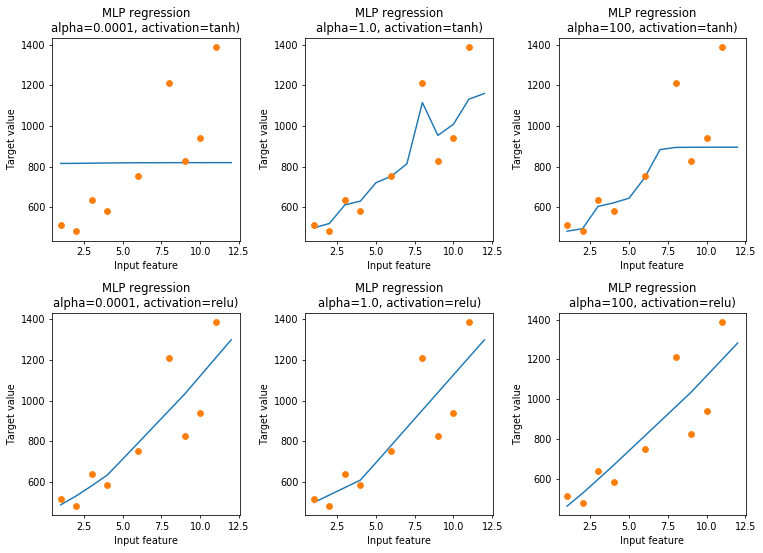

In [186]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)
X = np.array([1,2,3,4,5,6,7,8,9,10,11,12]).reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, test_data_two, random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X)
        #thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X, y_predict_output)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()